In [1]:
# Imports
import gensim
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Gensim
from gensim.parsing.preprocessing import preprocess_string, strip_tags
from gensim.parsing.preprocessing import strip_punctuation, strip_multiple_whitespaces
from gensim.parsing.preprocessing import stem_text, strip_numeric, strip_short
from gensim.corpora import Dictionary

# Scitkit Learn Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD as LSA
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [2]:
fp = None

In [3]:
def clean_str(string):
    """Cleans and tokenizes a string with some functions from gensim.

    Input: A string
    Output: A lists of tokenized words"""
    return preprocess_string(string, filters=[strip_tags, strip_punctuation,
                                    strip_numeric, strip_multiple_whitespaces,
                                    strip_short])

In [4]:
def create_vocabulary(series_of_strings, min_count=20, max_percent=0.05, keep_n=10000):
    """Tokenizes words in the list_of_strings and filters extremes.
    Returns a set of words that comprise a vocabulary based on the
    input strings"""
    # all_words = series_of_strings.apply(lambda row: preprocess_string(row))
    all_words = Dictionary(series_of_strings.apply(lambda row: clean_str(row)))
    all_words.filter_extremes(no_below=min_count, no_above=max_percent, keep_n=keep_n)
    return set(all_words.values())

In [5]:
def tokenize(string):
    """Cleans and tokenizes a string and returns a list of strings that are in
    VOCABULARY"""
    words_in_string = clean_str(string)
    return ' '.join([word for word in words_in_string if word in VOCABULARY])

In [6]:
def run_models(data, vectorizers, models, n_topics, tokenizer, vocabulary):
    """Provides a pipeline functionality in order to run multiple vectorizers,
    models and number of topics."""
    return_model = None
    for vkey, vectorizer in vectorizers.items():
        vec = vectorizer(stop_words='english', ngram_range=(1,2))
        vectorizer_fit = vec.fit_transform(data)
        for mkey, model in models.items():
            for n in n_topics:
                model_instance = model(n_components=n)
                word_vector = model_instance.fit_transform(vectorizer_fit)
                return_model = word_vector
                print('notes/output_file_{}_{}_{}.txt'.format(vkey,mkey, n))

                terms = vec.get_feature_names()
                with open('/Users/scott/p4/notes/output_file_{}_{}_{}.txt'.format(vkey,mkey, n), 'w') as notes:
                    for idx, comp in enumerate(model_instance.components_):
                        terms_in_components = zip(terms, comp)
                        sorted_terms = sorted(terms_in_components, key=lambda x: x[1], reverse=True)
                        notes.write('Topic {}\n:'.format(idx))
                        for i, term in enumerate(sorted_terms[:10]):
                            notes.write('{} '.format(term[0]))
                        notes.write('\n')

#                 print('Pickling Vectorizer...')
#                 with open('pickles/vectorizer_{}_{}_{}.pkl'.format(vkey,mkey, n), 'wb') as f:
#                     pickle.dump(vec, f)

#                 print('Pickling model object...')
#                 with open('pickles/model_{}_{}_{}.pkl'.format(vkey,mkey, n), 'wb') as f:
#                     pickle.dump(model_instance, f)

#                 print('Pickling document topic object...')
#                 with open('pickles/doc_topic_{}_{}_{}.pkl'.format(vkey,mkey, n), 'wb') as f:
#                     pickle.dump(word_vector, f)
    return return_model

In [7]:
def find_best_num_clusters(matrix, cluster_rng):
    """Runs KMeans on the matrix for each number in the range -1. 
    Returns a list of cluster and interia measurements."""
    clusters_errors = []
    for n in cluster_rng:
        km = KMeans(n_clusters=n)
        km.fit(matrix)
        clusters_errors.append((n, km.inertia_))
    return clusters_errors

In [8]:
# Load dataset
if not fp:
    fp = pd.read_csv('~/p4/data/interim/fp_posts.csv')
    fp = fp.drop(['url', 'img', 'created'], axis=1)
    fp['before'] = fp['title'].copy()
    fp['title'] = fp.title.str.replace(r'\d+', '')
    fp['title'] = fp.title.str.replace(r'\[.*\]', '')
    fp['title'] = fp.title.str.replace(r'[^A-Za-z\s]', '')

In [9]:
# Create a vocabulary. The vocabulary filters out extremes values so that
# only words that appear more than a set number of times are included.
VOCABULARY = create_vocabulary(fp.title, min_count=20)
# with open('pickles/vocabulary.pkl', 'wb') as f:
#     pickle.dump(VOCABULARY, f)

fp.title = fp.apply(lambda row: tokenize(row['title']),axis=1)

# Set up test parameters and run models.
test_vecs = {'cv': CountVectorizer, 'tfidf': TfidfVectorizer}
test_models = {'LSA': LSA, 'NMF': NMF, 'LDA': LDA}
test_n_topics = [10, 15, 20, 25, 50]
run_models(fp.title, test_vecs, test_models, test_n_topics, tokenize, VOCABULARY)

notes/output_file_cv_LSA_10.txt
notes/output_file_cv_LSA_15.txt
notes/output_file_cv_LSA_20.txt
notes/output_file_cv_LSA_25.txt
notes/output_file_cv_LSA_50.txt
notes/output_file_cv_NMF_10.txt
notes/output_file_cv_NMF_15.txt
notes/output_file_cv_NMF_20.txt
notes/output_file_cv_NMF_25.txt
notes/output_file_cv_NMF_50.txt
notes/output_file_cv_LDA_10.txt
notes/output_file_cv_LDA_15.txt
notes/output_file_cv_LDA_20.txt
notes/output_file_cv_LDA_25.txt
notes/output_file_cv_LDA_50.txt
notes/output_file_tfidf_LSA_10.txt
notes/output_file_tfidf_LSA_15.txt
notes/output_file_tfidf_LSA_20.txt
notes/output_file_tfidf_LSA_25.txt
notes/output_file_tfidf_LSA_50.txt
notes/output_file_tfidf_NMF_10.txt
notes/output_file_tfidf_NMF_15.txt
notes/output_file_tfidf_NMF_20.txt
notes/output_file_tfidf_NMF_25.txt
notes/output_file_tfidf_NMF_50.txt
notes/output_file_tfidf_LDA_10.txt
notes/output_file_tfidf_LDA_15.txt
notes/output_file_tfidf_LDA_20.txt
notes/output_file_tfidf_LDA_25.txt
notes/output_file_tfidf_LDA_50

array([[0.00565652, 0.00565652, 0.00565652, ..., 0.00565652, 0.00565652,
        0.00565652],
       [0.004748  , 0.004748  , 0.004748  , ..., 0.29158645, 0.004748  ,
        0.004748  ],
       [0.00628325, 0.00628325, 0.00628325, ..., 0.00628325, 0.11965841,
        0.00628325],
       ...,
       [0.01      , 0.01      , 0.01      , ..., 0.01      , 0.01      ,
        0.01      ],
       [0.00743752, 0.00743752, 0.00743752, ..., 0.00743752, 0.00743752,
        0.00743752],
       [0.00568512, 0.00568512, 0.00568512, ..., 0.00568512, 0.72142935,
        0.00568512]])

In [10]:
# Run a singular test and caputre the document-topic vector for clustering.
test_vecs = {'tfidf': TfidfVectorizer}
test_models = {'NMF': NMF}
test_n_topics = [20]
fit_model = run_models(fp.title, test_vecs, test_models, test_n_topics, tokenize, VOCABULARY)

notes/output_file_tfidf_NMF_20.txt


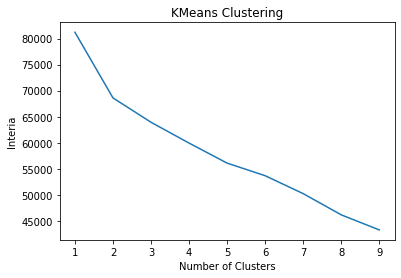

In [11]:
# Run the normalize document-topic vector though a range of values to
# look for an elbow.
nm = normalize(fit_model)

nc = range(1,10)
errors = find_best_num_clusters(nm, nc)

e1 = [x[1] for x in errors]

plt.title('KMeans Clustering');
plt.xlabel('Number of Clusters');
plt.ylabel('Interia');
plt.plot(nc, e1);
plt.savefig('../images/Clustering_Undecomposed.png')